In [1]:
!pip -q install yfinance scikit-learn

import os
import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score

import matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)


In [2]:
# Simple starter universe (replace with your own list later)
tickers = ["AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","JPM","XOM","UNH","AVGO","LLY","COST","WMT","HD"]


In [3]:
def get_prices(tickers, start="2010-01-01"):
    data = yf.download(tickers, start=start, auto_adjust=True, progress=False, group_by="ticker")
    return data

px = get_prices(tickers, start="2012-01-01")
px.tail()


Ticker             UNH                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2026-02-02  286.019989  290.399994  282.279999  285.589996   8664200   
2026-02-03  284.700012  288.089996  278.600006  284.179993  10809100   
2026-02-04  282.010010  284.500000  274.049988  275.920013  12944100   
2026-02-05  274.290009  276.890015  266.290009  268.549988  13035300   
2026-02-06  267.059998  277.809998  266.410004  276.649994   9560800   

Ticker            NVDA                                                 ...  \
Price             Open        High         Low       Close     Volume  ...   
Date                                                                   ...   
2026-02-02  187.199997  190.300003  184.880005  185.610001  165794100  ...   
2026-02-03  186.240005  186.270004  176.229996  180.339996  204019600  ...   
2026-02-04  179.460007  179.580002  171.910004  174.190002  207014100  ...   
2026-02-05  174.929993  176.820007  171.029999  171.880005  206312900  ...   
2026-02-06  176.690002  187.000000  174.600006  185.410004  230887800  ...   

Ticker            AMZN                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2026-02-02  238.309998  245.630005  238.169998  242.960007   37546100   
2026-02-03  244.979996  246.350006  235.449997  238.619995   53831300   
2026-02-04  238.860001  238.860001  231.820007  232.990005   51299900   
2026-02-05  224.910004  226.309998  220.380005  222.690002  103509200   
2026-02-06  202.699997  211.440002  200.309998  210.320007  179021600   

Ticker            MSFT                                                
Price             Open        High         Low       Close    Volume  
Date                                                                  
2026-02-02  430.239990  430.739990  422.250000  423.369995  42219900  
2026-02-03  422.010010  422.049988  408.559998  411.209991  61424100  
2026-02-04  411.000000  419.799988  409.239990  414.190002  45012400  
2026-02-05  407.440002  408.299988  392.320007  393.670013  66289200  
2026-02-06  399.170013  401.790009  392.920013  401.140015  53403600  

[5 rows x 75 columns]

In [4]:
def build_features_one(ticker, px):
    df = px[ticker].copy()  # columns: Open High Low Close Volume
    df = df.dropna()

    close = df["Close"]
    vol = df["Volume"]

    # Returns (momentum)
    df["ret_20"]  = close.pct_change(20)
    df["ret_60"]  = close.pct_change(60)
    df["ret_120"] = close.pct_change(120)

    # Moving averages
    df["ma_50"]  = close.rolling(50).mean()
    df["ma_200"] = close.rolling(200).mean()
    df["dist_ma50"]  = (close / df["ma_50"]) - 1
    df["dist_ma200"] = (close / df["ma_200"]) - 1

    # Breakout vs 60-day high
    df["high_60"] = close.rolling(60).max()
    df["breakout_60"] = (close / df["high_60"]) - 1

    # Volume spike
    df["vol_ma20"] = vol.rolling(20).mean()
    df["vol_ratio"] = vol / df["vol_ma20"]

    # Volatility proxy
    df["volatility_20"] = close.pct_change().rolling(20).std()

    df["ticker"] = ticker
    return df

frames = [build_features_one(t, px) for t in tickers if t in px.columns.get_level_values(0)]
feat = pd.concat(frames).reset_index().rename(columns={"index":"date"})
feat.head()


Price,Date,Open,High,Low,Close,Volume,ret_20,ret_60,ret_120,ma_50,ma_200,dist_ma50,dist_ma200,high_60,breakout_60,vol_ma20,vol_ratio,volatility_20,ticker
0,2012-01-03,12.278332,12.371304,12.266335,12.333215,302220800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
1,2012-01-04,12.296329,12.436688,12.274736,12.399498,260022000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
2,2012-01-05,12.444784,12.552751,12.376404,12.537156,271269600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
3,2012-01-06,12.589340,12.678712,12.572844,12.668216,318292800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
4,2012-01-09,12.761188,12.828667,12.636724,12.648121,394024400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL


In [6]:
H = 60  # horizon
THRESH = 0.20  # 20% forward return = "growth"

feat["fwd_ret_60"] = feat.groupby("ticker")["Close"].pct_change(-H) * -1
feat["y"] = (feat["fwd_ret_60"] >= THRESH).astype(int)

# Drop rows that don't have enough history/future
feat = feat.dropna(subset=["ret_20","ret_60","ret_120","dist_ma50","dist_ma200","breakout_60","vol_ratio","volatility_20","y"])
feat[["Date","ticker","fwd_ret_60","y"]].head()


Price,Date,ticker,fwd_ret_60,y
199,2012-10-16,AAPL,-0.331157,0
200,2012-10-17,AAPL,-0.267916,0
201,2012-10-18,AAPL,-0.252813,0
202,2012-10-19,AAPL,-0.214135,0
203,2012-10-22,AAPL,-0.250366,0


In [13]:
feat = feat.sort_values("Date")
dates = sorted(feat["Date"].unique())


In [14]:
print(feat.index)


Index([  199, 14379, 24919, 32009, 21374, 39099, 46189, 35554, 10834,  7289,
       ...
       28264, 21174, 49534,  3544, 31809, 35354, 17724, 42444, 14179, 53079],
      dtype='int64', length=50095)


In [15]:
feat = feat.reset_index()
feat = feat.rename(columns={"index":"date"})


In [16]:
feat = feat.sort_values("date")


In [17]:
assert "date" in feat.columns, "Date column missing"


In [18]:
FEATURES = ["ret_20","ret_60","ret_120","dist_ma50","dist_ma200","breakout_60","vol_ratio","volatility_20"]

feat = feat.sort_values("date")
dates = sorted(feat["date"].unique())

# Train on first 70%, test on last 30%
cut = int(len(dates) * 0.7)
train_dates = dates[:cut]
test_dates  = dates[cut:]

train = feat[feat["date"].isin(train_dates)]
test  = feat[feat["date"].isin(test_dates)]

X_train, y_train = train[FEATURES], train["y"]
X_test,  y_test  = test[FEATURES],  test["y"]

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

test = test.copy()
test["p"] = model.predict_proba(X_test)[:,1]

print("AUC:", roc_auc_score(y_test, test["p"]))


AUC: 0.6790706387730996


In [19]:
latest = feat["date"].max()
watch = feat[feat["date"] == latest].copy()

watch["p"] = model.predict_proba(watch[FEATURES])[:,1]
watch = watch.sort_values("p", ascending=False)

watchlist_path = "outputs/watchlist_latest.csv"
watch[["date","ticker","p","ret_60","breakout_60","vol_ratio","volatility_20"]].to_csv(watchlist_path, index=False)

watch.head(10), watchlist_path


(Price   date       Date        Open        High         Low       Close  \
 50094  53079 2026-02-06  381.339996  386.369995  379.100006  385.149994   
 
 Price     Volume   ret_20    ret_60   ret_120  ...  dist_ma200     high_60  \
 50094  4677800.0  0.07117  0.046462 -0.023886  ...    0.034759  387.200012   
 
 Price  breakout_60   vol_ma20  vol_ratio  volatility_20  ticker  fwd_ret_60  \
 50094    -0.005294  4583215.0   1.020637        0.01461      HD         NaN   
 
 Price  y         p  
 50094  0  0.050759  
 
 [1 rows x 23 columns],
 'outputs/watchlist_latest.csv')

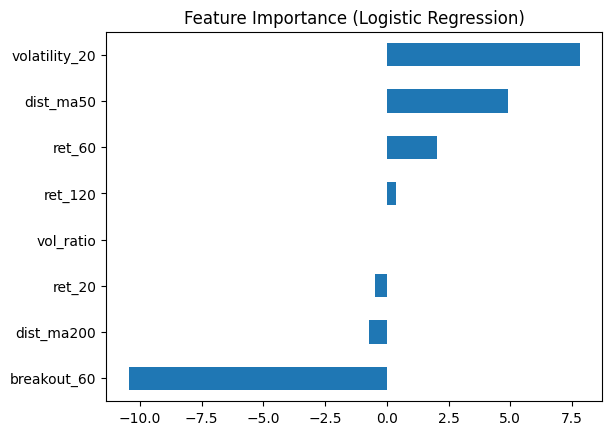

In [20]:
import numpy as np

coef = pd.Series(model.coef_[0], index=FEATURES)
coef.sort_values().plot(kind="barh")
plt.title("Feature Importance (Logistic Regression)")
plt.show()


In [22]:
!pip -q install yfinance scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report


In [23]:
TICKERS = [
    "AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","JPM","XOM","UNH",
    "AVGO","COST","LLY","PG","MA","HD","MRK","PEP","ABBV","KO"
]


In [24]:
def load_prices(tickers, start="2015-01-01", end=None):
    px = yf.download(
        tickers,
        start=start,
        end=end,
        auto_adjust=True,
        group_by="ticker",
        progress=False,
        threads=True
    )

    frames = []
    for t in tickers:
        if (t,) in px.columns:  # rare format
            df = px[t].copy()
        elif t in px.columns.get_level_values(0):
            df = px[t].copy()
        else:
            continue

        df = df.reset_index()
        df.columns = [c.lower() for c in df.columns]  # date, open, high, low, close, volume
        df["ticker"] = t
        frames.append(df)

    out = pd.concat(frames, ignore_index=True)
    out = out.dropna(subset=["date","close"])
    out = out.sort_values(["ticker","date"])
    return out

prices = load_prices(TICKERS, start="2015-01-01")
prices.head(), prices["ticker"].nunique(), prices["date"].min(), prices["date"].max()


/tmp/ipython-input-1505882846.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (t,) in px.columns:  # rare format
/tmp/ipython-input-1505882846.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (t,) in px.columns:  # rare format
/tmp/ipython-input-1505882846.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (t,) in px.columns:  # rare format
/tmp/ipython-input-1505882846.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (t,) in px.columns:  # rare format
/tmp/ipython-input-1505882846.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (t,) in px.columns:  # rare format
/tmp/ipython-input-1505882846.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (t,) in px.columns:  # rare format
/tmp/ipython-input-1505882846.py:14: PerformanceWarning: indexing past lexsort depth may impact performanc

(        date       open       high        low      close     volume ticker
 0 2015-01-02  24.694229  24.705314  23.798595  24.237545  212818400   AAPL
 1 2015-01-05  24.006986  24.086795  23.368515  23.554735  257142000   AAPL
 2 2015-01-06  23.619036  23.816342  23.195604  23.556963  263188400   AAPL
 3 2015-01-07  23.765347  23.987038  23.654501  23.887278  160423600   AAPL
 4 2015-01-08  24.215380  24.862719  24.097882  24.805079  237458000   AAPL,
 20,
 Timestamp('2015-01-02 00:00:00'),
 Timestamp('2026-02-06 00:00:00'))

In [25]:
def add_features(df):
    df = df.sort_values(["ticker","date"]).copy()

    # Returns
    df["ret_1"] = df.groupby("ticker")["close"].pct_change(1)
    df["ret_5"] = df.groupby("ticker")["close"].pct_change(5)
    df["ret_20"] = df.groupby("ticker")["close"].pct_change(20)
    df["ret_60"] = df.groupby("ticker")["close"].pct_change(60)

    # Moving averages
    df["ma20"]  = df.groupby("ticker")["close"].transform(lambda s: s.rolling(20).mean())
    df["ma50"]  = df.groupby("ticker")["close"].transform(lambda s: s.rolling(50).mean())
    df["ma200"] = df.groupby("ticker")["close"].transform(lambda s: s.rolling(200).mean())

    df["dist_ma50"]  = (df["close"] / df["ma50"]) - 1
    df["dist_ma200"] = (df["close"] / df["ma200"]) - 1

    # Volatility
    df["volatility_20"] = df.groupby("ticker")["ret_1"].transform(lambda s: s.rolling(20).std())

    # Volume signal (if volume exists)
    if "volume" in df.columns:
        df["vol_ma20"] = df.groupby("ticker")["volume"].transform(lambda s: s.rolling(20).mean())
        df["vol_ratio"] = df["volume"] / df["vol_ma20"]
    else:
        df["vol_ratio"] = np.nan

    # Breakout style feature: close relative to last 60-day high
    df["high_60"] = df.groupby("ticker")["close"].transform(lambda s: s.rolling(60).max())
    df["breakout_60"] = (df["close"] / df["high_60"])  # ~1.0 means near breakout

    return df

feat = add_features(prices)
feat.tail()


,date,open,high,low,close,volume,ticker,ret_1,ret_5,ret_20,...,ma20,ma50,ma200,dist_ma50,dist_ma200,volatility_20,vol_ma20,vol_ratio,high_60,breakout_60
25114,2026-02-02,139.830002,140.320007,138.059998,138.399994,27735600,XOM,-0.021216,0.026402,0.128414,...,130.722500,122.9236,112.434147,0.125903,0.230943,0.018053,20888245.0,1.327809,141.399994,0.978784
25115,2026-02-03,138.639999,145.009995,138.309998,143.729996,37577800,XOM,0.038512,0.050427,0.146538,...,131.641000,123.4512,112.645795,0.164266,0.275946,0.019152,21261525.0,1.767408,143.729996,1.000000
25116,2026-02-04,144.119995,147.839996,144.119995,147.589996,29426200,XOM,0.026856,0.072758,0.219248,...,132.967999,124.0626,112.863458,0.189641,0.307686,0.016951,21566405.0,1.364446,147.589996,1.000000
25117,2026-02-05,146.580002,146.729996,143.800003,146.080002,18431700,XOM,-0.010231,0.039641,0.232847,...,134.347499,124.6426,113.081211,0.171991,0.291815,0.016044,21470340.0,0.858473,147.589996,0.989769
25118,2026-02-06,146.619995,149.570007,146.089996,149.050003,17206600,XOM,0.020331,0.054102,0.212676,...,135.654499,125.3042,113.299459,0.189505,0.315540,0.014972,21319035.0,0.807100,149.050003,1.000000


In [26]:
H = 20             # forward horizon (about 1 month trading days)
THRESH = 0.10      # +10% move target

def add_label(df, horizon=20, thresh=0.10):
    df = df.sort_values(["ticker","date"]).copy()
    fwd_close = df.groupby("ticker")["close"].shift(-horizon)
    df["fwd_ret_h"] = (fwd_close / df["close"]) - 1
    df["y"] = (df["fwd_ret_h"] >= thresh).astype(int)
    return df

feat = add_label(feat, horizon=H, thresh=THRESH)
feat[["ticker","date","close","fwd_ret_h","y"]].dropna().head()


,ticker,date,close,fwd_ret_h,y
0,AAPL,2015-01-02,24.237545,0.085064,0
1,AAPL,2015-01-05,23.554735,0.116706,1
2,AAPL,2015-01-06,23.556963,0.125164,1
3,AAPL,2015-01-07,23.887278,0.117525,1
4,AAPL,2015-01-08,24.805079,0.067114,0


In [27]:
FEATURES = ["ret_20","ret_60","dist_ma50","dist_ma200","breakout_60","vol_ratio","volatility_20"]

data = feat.dropna(subset=FEATURES + ["y", "date"]).copy()
data = data.sort_values("date")

print("Rows:", len(data))
print("Positive rate:", data["y"].mean())


Rows: 51840
Positive rate: 0.1148341049382716


In [28]:
split_date = data["date"].quantile(0.80)  # last 20% time for test
train = data[data["date"] <= split_date].copy()
test  = data[data["date"] > split_date].copy()

X_train, y_train = train[FEATURES], train["y"]
X_test,  y_test  = test[FEATURES],  test["y"]

model = LogisticRegression(max_iter=2000, class_weight="balanced")
model.fit(X_train, y_train)

test = test.copy()
test["p"] = model.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, test["p"])
print("AUC:", round(auc, 4))
print(classification_report(y_test, (test["p"] > 0.5).astype(int)))


AUC: 0.6546
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      9104
           1       0.19      0.52      0.28      1256

    accuracy                           0.68     10360
   macro avg       0.55      0.61      0.54     10360
weighted avg       0.83      0.68      0.73     10360



In [29]:
latest_date = test["date"].max()
today_board = test[test["date"] == latest_date].copy()

today_board = today_board.sort_values("p", ascending=False)[
    ["date","ticker","p"] + FEATURES
].head(15)

today_board


,date,ticker,p,ret_20,ret_60,dist_ma50,dist_ma200,breakout_60,vol_ratio,volatility_20
30700,2026-02-06,AVGO,0.762594,0.001323,-0.069290,-0.051760,0.080064,0.807703,1.178051,0.029463
27909,2026-02-06,UNH,0.734201,-0.202393,-0.133932,-0.149916,-0.137216,0.776540,0.762322,0.048118
5581,2026-02-06,MSFT,0.652407,-0.160988,-0.205749,-0.144472,-0.174335,0.786264,1.279396,0.029052
19536,2026-02-06,TSLA,0.648613,-0.056654,-0.076635,-0.075228,0.077613,0.839205,1.008060,0.025043
16745,2026-02-06,META,0.578895,0.023837,0.047865,0.008262,-0.034445,0.895911,0.946614,0.032245
25118,2026-02-06,XOM,0.555403,0.212676,0.271813,0.189505,0.315540,1.000000,0.807100,0.014972
47446,2026-02-06,MRK,0.552549,0.098567,0.417546,0.147683,0.389957,1.000000,0.939853,0.015050
11163,2026-02-06,AMZN,0.549365,-0.146047,-0.153301,-0.098505,-0.057653,0.844320,3.474232,0.021204
13954,2026-02-06,GOOGL,0.509624,-0.007928,0.113654,0.003602,0.352134,0.939393,1.511672,0.013376
36282,2026-02-06,LLY,0.487819,-0.024890,0.096307,0.003524,0.233499,0.953367,1.394384,0.035867


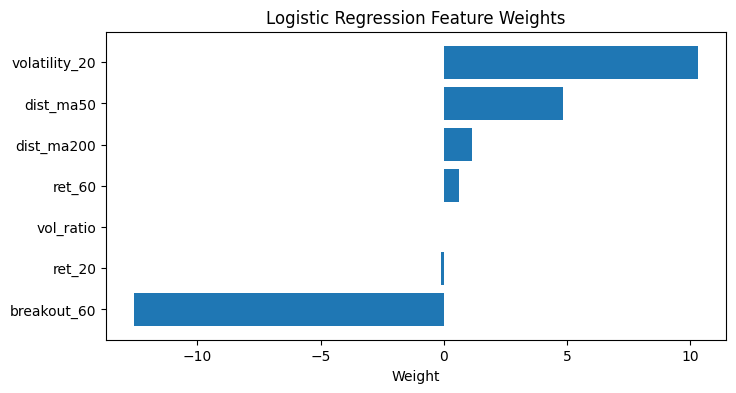

In [30]:
coefs = pd.Series(model.coef_[0], index=FEATURES).sort_values()

plt.figure(figsize=(8,4))
plt.barh(coefs.index, coefs.values)
plt.title("Logistic Regression Feature Weights")
plt.xlabel("Weight")
plt.show()


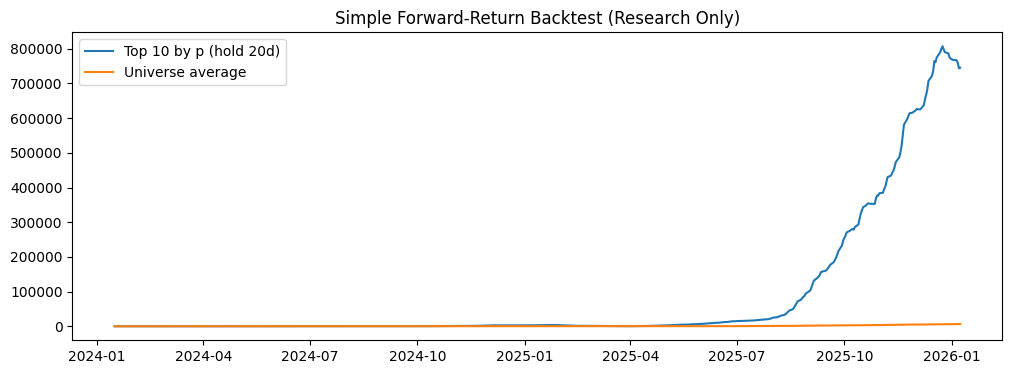

Strategy mean fwd return: 0.02873087874759134
Benchmark mean fwd return: 0.018355709777415616


In [31]:
K = 10

test2 = test.dropna(subset=["fwd_ret_h"]).copy()
daily = (
    test2.sort_values(["date","p"], ascending=[True, False])
        .groupby("date")
        .head(K)
)

strategy_daily_ret = daily.groupby("date")["fwd_ret_h"].mean()
benchmark_daily_ret = test2.groupby("date")["fwd_ret_h"].mean()

plt.figure(figsize=(12,4))
plt.plot((1 + strategy_daily_ret).cumprod(), label=f"Top {K} by p (hold {H}d)")
plt.plot((1 + benchmark_daily_ret).cumprod(), label="Universe average")
plt.title("Simple Forward-Return Backtest (Research Only)")
plt.legend()
plt.show()

print("Strategy mean fwd return:", strategy_daily_ret.mean())
print("Benchmark mean fwd return:", benchmark_daily_ret.mean())


In [32]:
if "date" not in feat.columns:
    feat = feat.reset_index()
    feat.columns = [c.lower() for c in feat.columns]
